In [1]:
# !pip install PyDrive2

import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Authenticate and initialize Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Helper functions for Google Drive

In [2]:
# Set base folder ID (e.g., 'conformal-op')
base_folder_id = '1nT1ST_KYr35h2bQp0djX8B8wFyWX1uyx'

def get_subfolder_id(parent_id, subfolder_name):
    file_list = drive.ListFile({'q': f"'{parent_id}' in parents and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == subfolder_name and file['mimeType'] == 'application/vnd.google-apps.folder':
            return file['id']
    return None

def download_file_by_name(folder_id, file_name, save_name):
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == file_name:
            print(f"Downloading {save_name}...")
            file.GetContentFile(save_name)
            print(f"{save_name} downloaded successfully!")
            return
    print(f"{file_name} not found in folder ID {folder_id}.")

def download_sample_files(folder_id, sample_folders, file_mappings):
    for sample in sample_folders:
        sample_folder_id = get_subfolder_id(folder_id, sample)
        if sample_folder_id:
            for original, save in file_mappings.items():
                download_file_by_name(sample_folder_id, original, f"{sample}_{save}")
        else:
            print(f"Folder {sample} not found.")

def create_drive_folder(parent_id, folder_name):
    file_list = drive.ListFile({
        'q': f"'{parent_id}' in parents and trashed=false and title='{folder_name}' and mimeType='application/vnd.google-apps.folder'"
    }).GetList()
    if file_list:
        return file_list[0]['id']
    folder_metadata = {
        "title": folder_name,
        "mimeType": "application/vnd.google-apps.folder",
        "parents": [{"id": parent_id}]
    }
    folder = drive.CreateFile(folder_metadata)
    folder.Upload()
    return folder['id']

def delete_existing_file_in_drive(folder_id, file_name):
    file_list = drive.ListFile({
        'q': f"'{folder_id}' in parents and trashed=false and title='{file_name}'"
    }).GetList()
    for file in file_list:
        file.Delete()
        # print(f"Deleted existing file: {file_name}")

def get_save_directory(sample_id):
    parent_id = base_folder_id
    folder_structure = ["reports", "figures", "3.3-nm-figures", f"sample_{sample_id}"]
    for folder_name in folder_structure:
        parent_id = create_drive_folder(parent_id, folder_name)
    return parent_id

def save_plot_to_drive(fig, file_name, folder_id):
    delete_existing_file_in_drive(folder_id, file_name)
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
        local_path = tmp_file.name
        fig.savefig(local_path, bbox_inches="tight")
    plot_file = drive.CreateFile({'title': file_name, 'parents': [{'id': folder_id}]})
    plot_file.SetContentFile(local_path)
    plot_file.Upload()
    os.remove(local_path)
    print(f"Plot saved to Google Drive in folder ID: {folder_id}")

### Load data

In [3]:
models_folder_id = get_subfolder_id(base_folder_id, 'models')
simulation_1_folder_id = get_subfolder_id(models_folder_id, 'simulation_1')

download_file_by_name(simulation_1_folder_id, 'simulation_1_test.csv', 'simulation_1_test.csv')

sample_folders = ['sample_0', 'sample_5']
file_mappings = {'cp_predictions.csv': 'cp_predictions.csv', 'non_cp_predictions.csv': 'non_cp_predictions.csv'}
download_sample_files(simulation_1_folder_id, sample_folders, file_mappings)

simulation_1_test.csv downloaded successfully!
sample_0_cp_predictions.csv downloaded successfully!
sample_0_non_cp_predictions.csv downloaded successfully!
sample_5_cp_predictions.csv downloaded successfully!
sample_5_non_cp_predictions.csv downloaded successfully!


In [4]:
simulation_1_test = pd.read_csv("simulation_1_test.csv")
sample_0_cp_predictions = pd.read_csv("sample_0_cp_predictions.csv")

print("simulation_1_test.csv:")
print(simulation_1_test.head())
print(simulation_1_test.shape)

print("\nsample_0_cp_predictions.csv:")
print(sample_0_cp_predictions.head())
print(sample_0_cp_predictions.shape)

simulation_1_test.csv:
          S     sigma       tau         r         C
0  1.012257  0.701505  0.090440  0.048415  0.092910
1  1.062039  0.701505  0.090440  0.048415  0.123634
2  1.088454  0.701505  0.090440  0.048415  0.141616
3  0.785035  0.701505  0.090440  0.048415  0.012098
4  0.903044  0.902738  0.183897  0.026479  0.104117
(500000, 5)

sample_0_cp_predictions.csv:
         lb        pp        ub  valid  pp_valid
0  0.096920  0.089069  0.120684   True     False
1  0.120834  0.118994  0.151041   True     False
2  0.142237  0.140289  0.173561   True     False
3  0.010710  0.033832  0.053367   True      True
4  0.089533  0.103883  0.165153   True      True
(500000, 5)


### Plotting functions

In [18]:
def plot_prediction_intervals(predictions_path, test_data_path, method_name, sample_id, sample_size, n, save=True):
    print(f"{method_name} - Prediction Intervals for Sample ID: {sample_id}")

    predictions = pd.read_csv(predictions_path).rename(columns={
        'lb': 'Lower Bound', 'pp': 'Point Prediction', 'ub': 'Upper Bound'
    })
    test_data = pd.read_csv(test_data_path).rename(columns={
        'S': 'moneyness', 'sigma': 'volatility',
        'tau': 'time_to_maturity', 'r': 'interest_rate',
        'C': 'call_price'
    })

    within_interval = (predictions['Lower Bound'] <= test_data['call_price']) & \
                      (test_data['call_price'] <= predictions['Upper Bound'])
    covered = within_interval.sum()
    missed = len(test_data) - covered

    print(f"Training Sample Size: {sample_size:,}")
    print(f"Covered Intervals: {covered:,}")
    print(f"Missed Intervals: {missed:,}")
    print(f"Note: Every {n:,}-th data point is plotted.\n")

    features = ['moneyness', 'volatility', 'time_to_maturity', 'interest_rate']
    feature_labels = ['Moneyness', 'Volatility', 'Time-to-Maturity', 'Interest Rate']
    feature_symbols = ['S/K', 'σ', 'τ (years)', 'r']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    for i, (feature, label, symbol) in enumerate(zip(features, feature_labels, feature_symbols)):
        missed_point_plotted = missed_interval_plotted = covered_plotted = False
        for j in range(0, len(test_data), n):
            x_value = test_data[feature].iloc[j]
            lower, upper = predictions['Lower Bound'].iloc[j], predictions['Upper Bound'].iloc[j]
            actual = test_data['call_price'].iloc[j]

            if actual < lower or actual > upper:
                axs[i].scatter(x_value, actual, color='orange', s=10, alpha=0.8, label="Missed Point" if not missed_point_plotted else "")
                missed_point_plotted = True

            if lower <= actual <= upper:
                axs[i].plot([x_value, x_value], [lower, upper], color='blue', alpha=0.6, label="Covered Interval" if not covered_plotted else "")
                covered_plotted = True
            else:
                axs[i].plot([x_value, x_value], [lower, upper], color='red', alpha=0.6, label="Missed Interval" if not missed_interval_plotted else "")
                missed_interval_plotted = True

        axs[i].set_xlabel(symbol)
        # axs[i].set_title(f'{label}')

    axs[0].set_ylabel('C/K')
    axs[2].set_ylabel('C/K')

    legend_elements = [
        Line2D([0], [0], marker='o', color='orange', linestyle='None', label='Missed Point'),
        Line2D([0], [0], color='red', label='Missed Interval'),
        Line2D([0], [0], color='blue', label='Covered Interval')
    ]
    axs[0].legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    if save:
        save_dir = get_save_directory(sample_id)
        save_plot_to_drive(fig, f"{method_name}_PIs_{sample_id}.png", save_dir)
    plt.show()

In [6]:
def plot_missed_rate(predictions_path, test_data_path, method_name, bins, sample_id, save=True):
    print(f"{method_name} - Missed Rate Analysis for Sample ID: {sample_id}")

    predictions = pd.read_csv(predictions_path).rename(columns={
        'lb': 'Lower Bound', 'pp': 'Point Prediction', 'ub': 'Upper Bound'
    })
    test_data = pd.read_csv(test_data_path).rename(columns={
        'S': 'moneyness', 'sigma': 'volatility',
        'tau': 'time_to_maturity', 'r': 'interest_rate',
        'C': 'call_price'
    })

    features = list(bins.keys())
    feature_labels = ['Moneyness', 'Volatility', 'Time-to-Maturity', 'Interest Rate']
    feature_symbols = ['S/K', 'σ', 'τ (years)', 'r']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    for i, feature in enumerate(features):
        missed_intervals = ~((predictions['Lower Bound'] <= test_data['call_price']) &
                             (test_data['call_price'] <= predictions['Upper Bound']))
        feature_data = test_data[feature]
        total_counts, _ = np.histogram(feature_data, bins=bins[feature])
        missed_counts, _ = np.histogram(feature_data[missed_intervals], bins=bins[feature])
        missed_rate = np.divide(missed_counts, total_counts, out=np.zeros_like(missed_counts, dtype=float), where=total_counts > 0)

        axs[i].bar(bins[feature][:-1], missed_rate, width=np.diff(bins[feature]), alpha=0.8, edgecolor='black')
        axs[i].set_xlabel(feature_symbols[i])
        # axs[i].set_title(f'{feature_labels[i]}')

    axs[0].set_ylabel('Missed Rate')
    axs[2].set_ylabel('Missed Rate')
    plt.tight_layout()
    if save:
        save_dir = get_save_directory(sample_id)
        save_plot_to_drive(fig, f"{method_name}_MISSED_RATE_{sample_id}.png", save_dir)
    plt.show()

In [7]:
def plot_invalid_intervals(predictions_path, test_data_path, method_name, bins, sample_id, save=True):
    print(f"{method_name} - Invalid Interval Analysis for Sample ID: {sample_id}")

    predictions = pd.read_csv(predictions_path).rename(columns={
        'lb': 'Lower Bound', 'pp': 'Point Prediction', 'ub': 'Upper Bound'
    })
    test_data = pd.read_csv(test_data_path).rename(columns={
        'S': 'moneyness', 'sigma': 'volatility',
        'tau': 'time_to_maturity', 'r': 'interest_rate',
        'C': 'call_price'
    })

    features = list(bins.keys())
    feature_labels = ['Moneyness', 'Volatility', 'Time-to-Maturity', 'Interest Rate']
    feature_symbols = ['S/K', 'σ', 'τ (years)', 'r']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    for i, feature in enumerate(features):
        invalid_intervals = predictions['valid'] == False
        feature_data = test_data[feature]
        total_counts, _ = np.histogram(feature_data, bins=bins[feature])
        invalid_counts, _ = np.histogram(feature_data[invalid_intervals], bins=bins[feature])
        invalid_rate = np.divide(invalid_counts, total_counts, out=np.zeros_like(invalid_counts, dtype=float), where=total_counts > 0)

        axs[i].bar(bins[feature][:-1], invalid_rate, width=np.diff(bins[feature]), alpha=0.8, edgecolor='black')
        axs[i].set_xlabel(feature_symbols[i])
        # axs[i].set_title(f'{feature_labels[i]}')

    axs[0].set_ylabel('Rate (valid=False)')
    axs[2].set_ylabel('Rate (valid=False)')
    plt.tight_layout()
    if save:
        save_dir = get_save_directory(sample_id)
        save_plot_to_drive(fig, f"{method_name}_INVALID_INTERVALS_{sample_id}.png", save_dir)
    plt.show()

In [8]:
def plot_invalid_pp(predictions_path, test_data_path, method_name, bins, sample_id, save=True):
    print(f"{method_name} - Invalid Point Prediction Analysis for Sample ID: {sample_id}")

    predictions = pd.read_csv(predictions_path).rename(columns={
        'lb': 'Lower Bound', 'pp': 'Point Prediction', 'ub': 'Upper Bound'
    })
    test_data = pd.read_csv(test_data_path).rename(columns={
        'S': 'moneyness', 'sigma': 'volatility',
        'tau': 'time_to_maturity', 'r': 'interest_rate',
        'C': 'call_price'
    })

    features = list(bins.keys())
    feature_labels = ['Moneyness', 'Volatility', 'Time-to-Maturity', 'Interest Rate']
    feature_symbols = ['S/K', 'σ', 'τ (years)', 'r']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    for i, feature in enumerate(features):
        invalid_point_predictions = predictions['pp_valid'] == False
        feature_data = test_data[feature]
        total_counts, _ = np.histogram(feature_data, bins=bins[feature])
        invalid_pp_counts, _ = np.histogram(feature_data[invalid_point_predictions], bins=bins[feature])
        invalid_pp_rate = np.divide(invalid_pp_counts, total_counts, out=np.zeros_like(invalid_pp_counts, dtype=float), where=total_counts > 0)

        axs[i].bar(bins[feature][:-1], invalid_pp_rate, width=np.diff(bins[feature]), alpha=0.8, edgecolor='black')
        axs[i].set_xlabel(feature_symbols[i])
        # axs[i].set_title(f'{feature_labels[i]}')

    axs[0].set_ylabel('Rate (pp_valid=False)')
    axs[2].set_ylabel('Rate (pp_valid=False)')
    plt.tight_layout()
    if save:
        save_dir = get_save_directory(sample_id)
        save_plot_to_drive(fig, f"{method_name}_INVALID_PP_{sample_id}.png", save_dir)
    plt.show()

### Process and visualize

In [9]:
test_data = pd.read_csv("simulation_1_test.csv").rename(columns={
    'S': 'moneyness', 'sigma': 'volatility',
    'tau': 'time_to_maturity', 'r': 'interest_rate',
    'C': 'call_price'
})

feature_ranges = test_data[['moneyness', 'volatility', 'time_to_maturity', 'interest_rate']].agg(['min', 'max'])

print("Minimum and Maximum values for each feature:")
print(feature_ranges)

Minimum and Maximum values for each feature:
     moneyness  volatility  time_to_maturity  interest_rate
min   0.467998    0.100014          0.055599          0.001
max   1.442970    0.999999          1.999992          0.050


In [10]:
# Define bin settings
bins = {
    'moneyness': np.linspace(0.4, 1.5, 10),
    'volatility': np.linspace(0, 1, 10),
    'time_to_maturity': np.linspace(0, 2, 10),
    'interest_rate': np.linspace(0, 0.05, 10)
}

In [11]:
cp_prediction_files = {
    "sample_0_cp_predictions.csv": (0, 5000),
    "sample_5_cp_predictions.csv": (5, 200000),
    # Add other sample files here as needed
}

non_cp_prediction_files = {
    "sample_0_non_cp_predictions.csv": (0, 5000),
    "sample_5_non_cp_predictions.csv": (5, 200000),
    # Add other sample files here as needed
}

test_data_path = "simulation_1_test.csv"

Processing CP Predictions for Sample ID: 0
CQR - Prediction Intervals for Sample ID: 0
Training Sample Size: 5,000
Covered Intervals: 436,972
Missed Intervals: 63,028
Note: Every 500-th data point is plotted.

Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


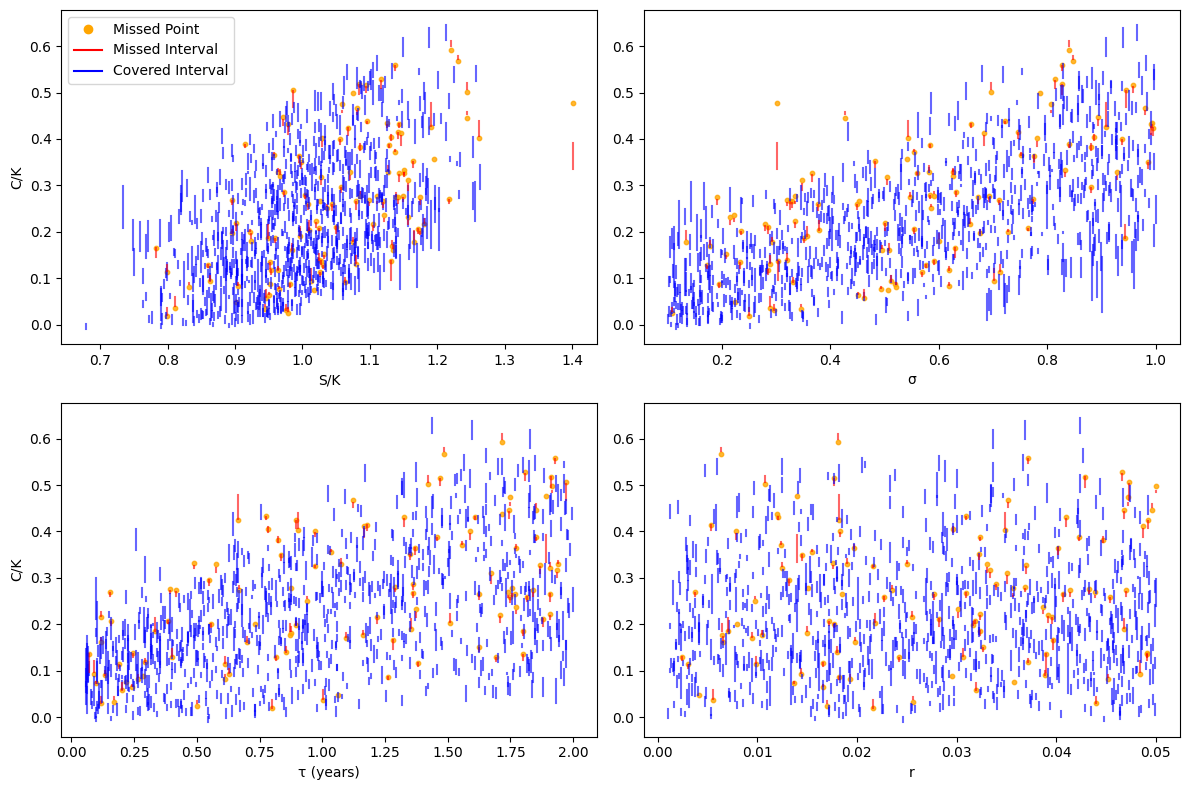

CQR - Missed Rate Analysis for Sample ID: 0
Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


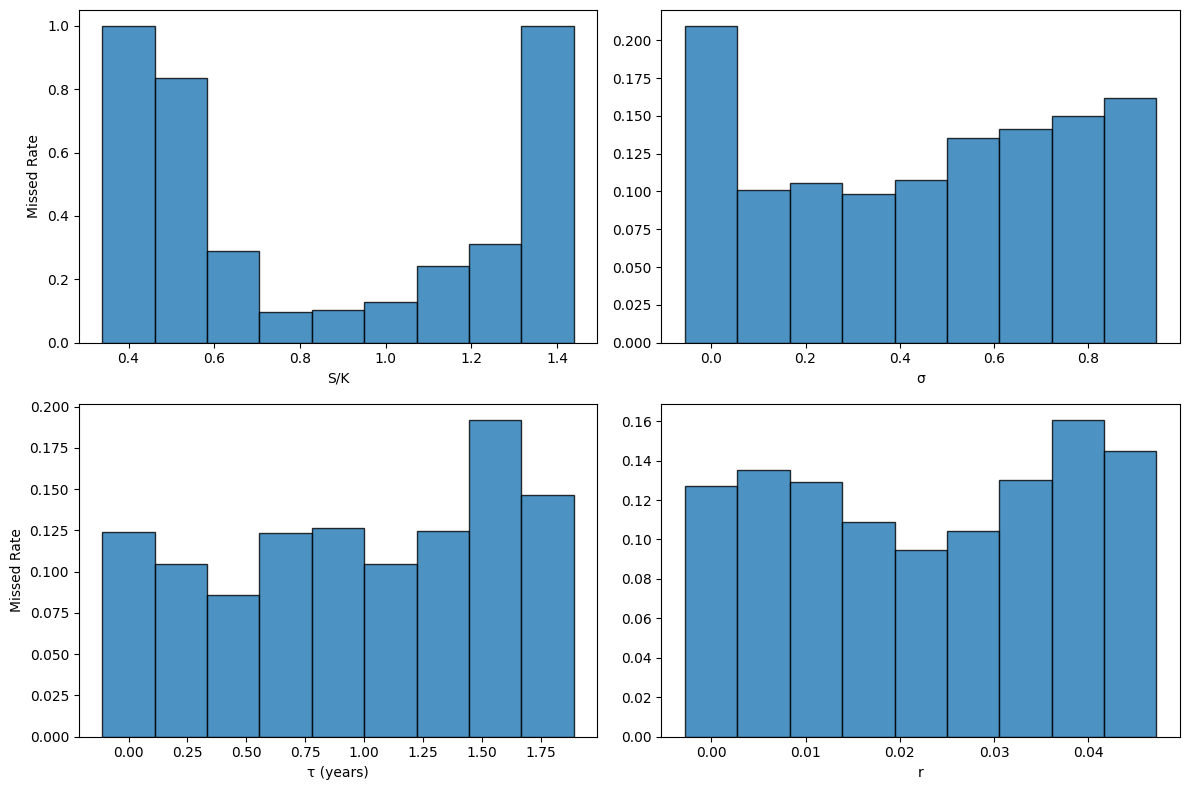

CQR - Invalid Interval Analysis for Sample ID: 0
Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


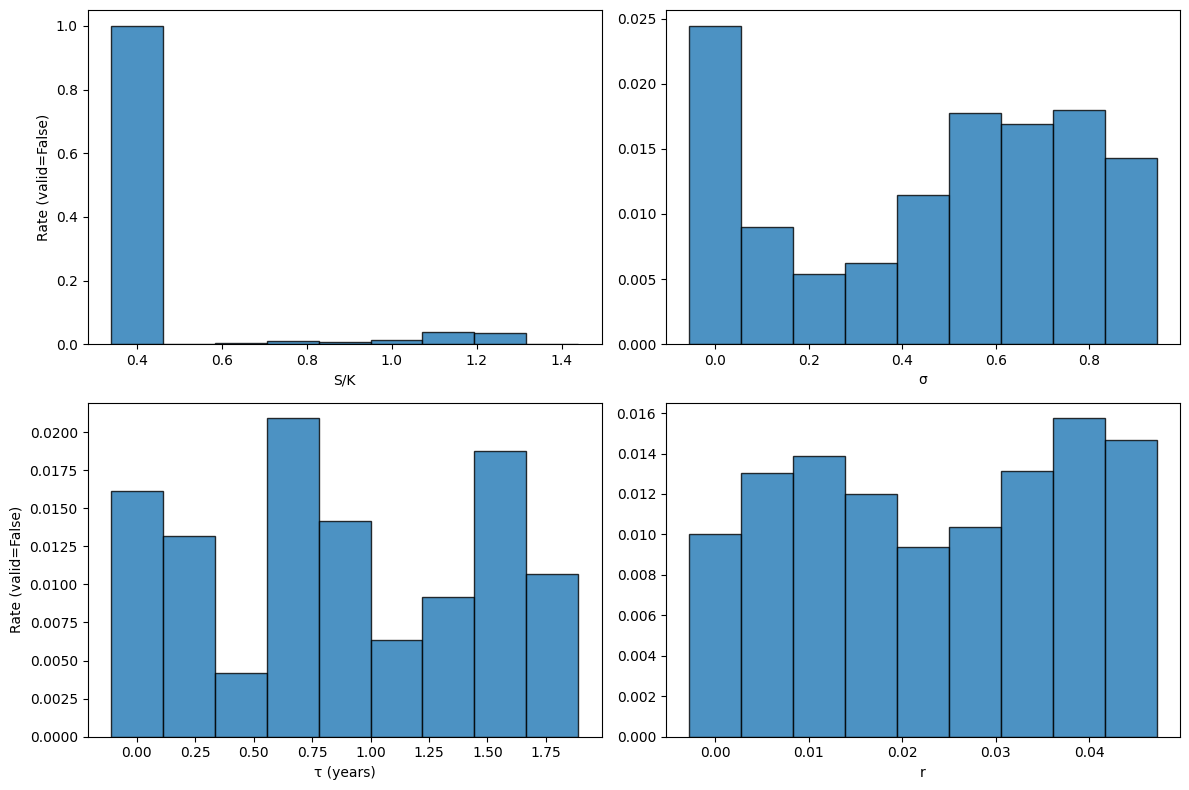

CQR - Invalid Point Prediction Analysis for Sample ID: 0
Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


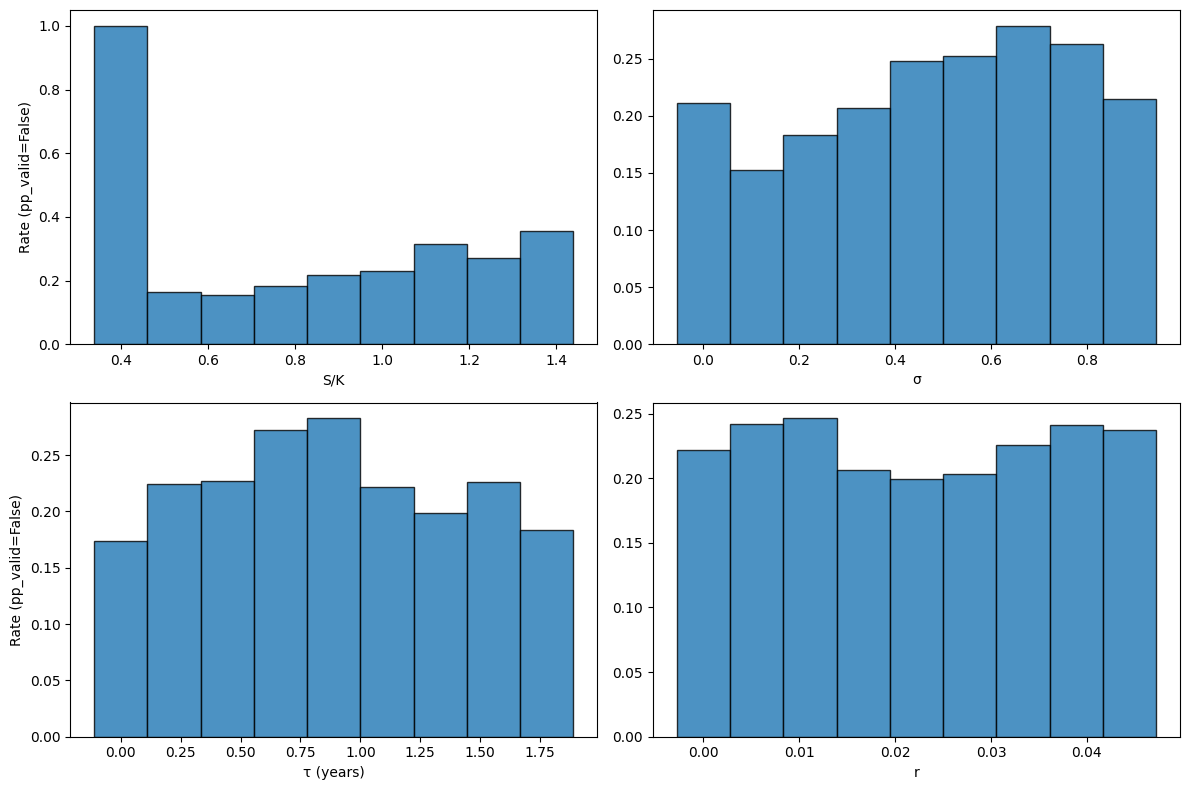

Processing CP Predictions for Sample ID: 5
CQR - Prediction Intervals for Sample ID: 5
Training Sample Size: 200,000
Covered Intervals: 441,989
Missed Intervals: 58,011
Note: Every 500-th data point is plotted.

Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


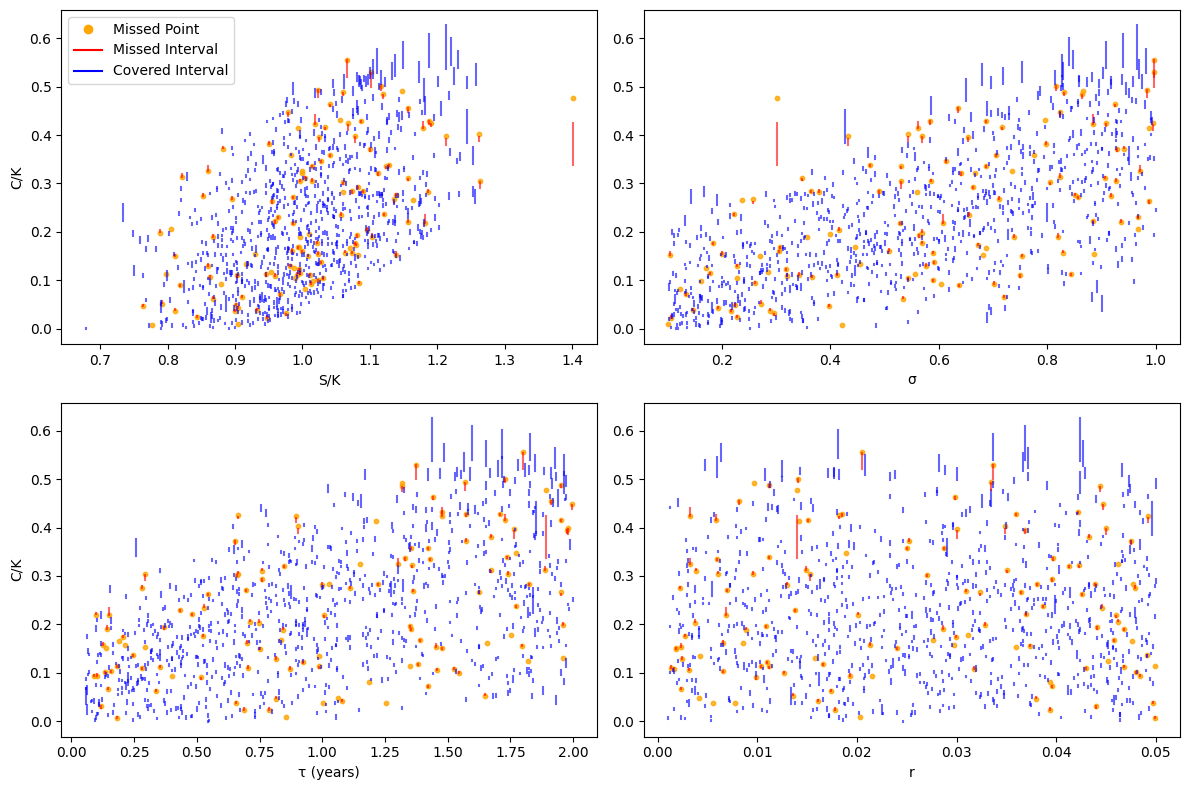

CQR - Missed Rate Analysis for Sample ID: 5
Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


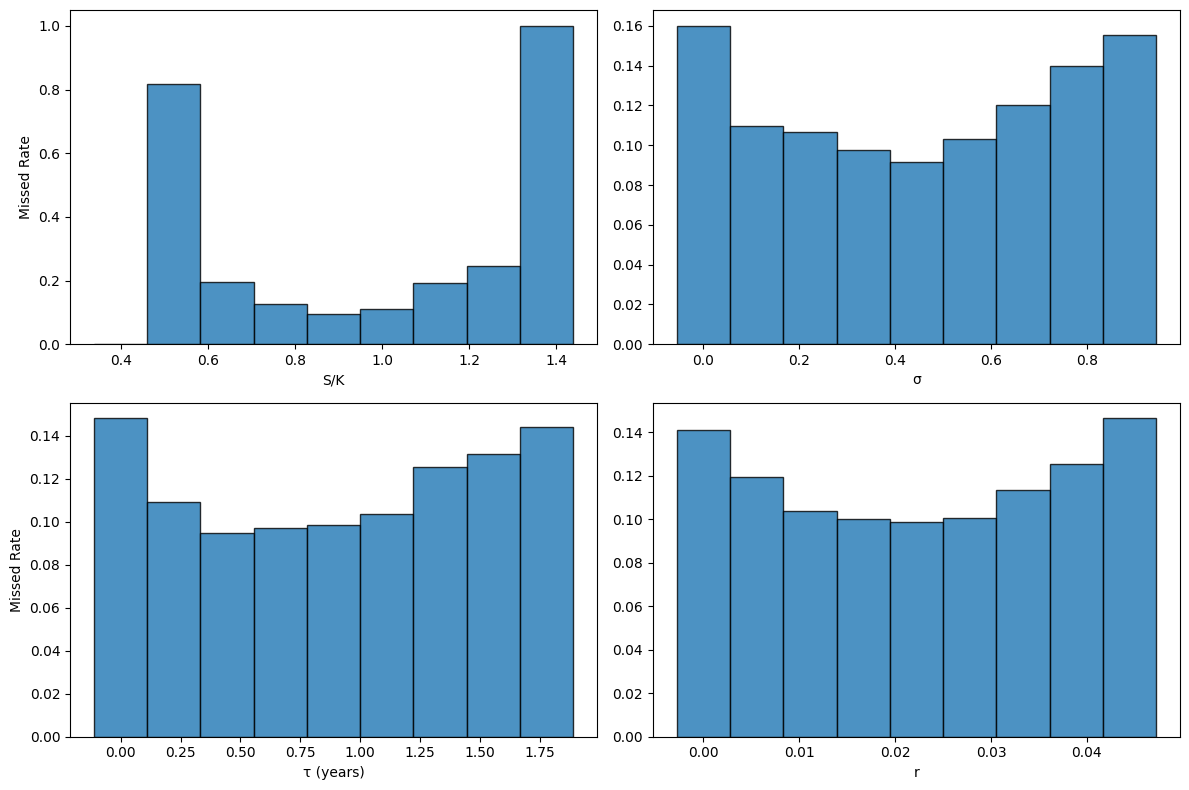

CQR - Invalid Interval Analysis for Sample ID: 5
Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


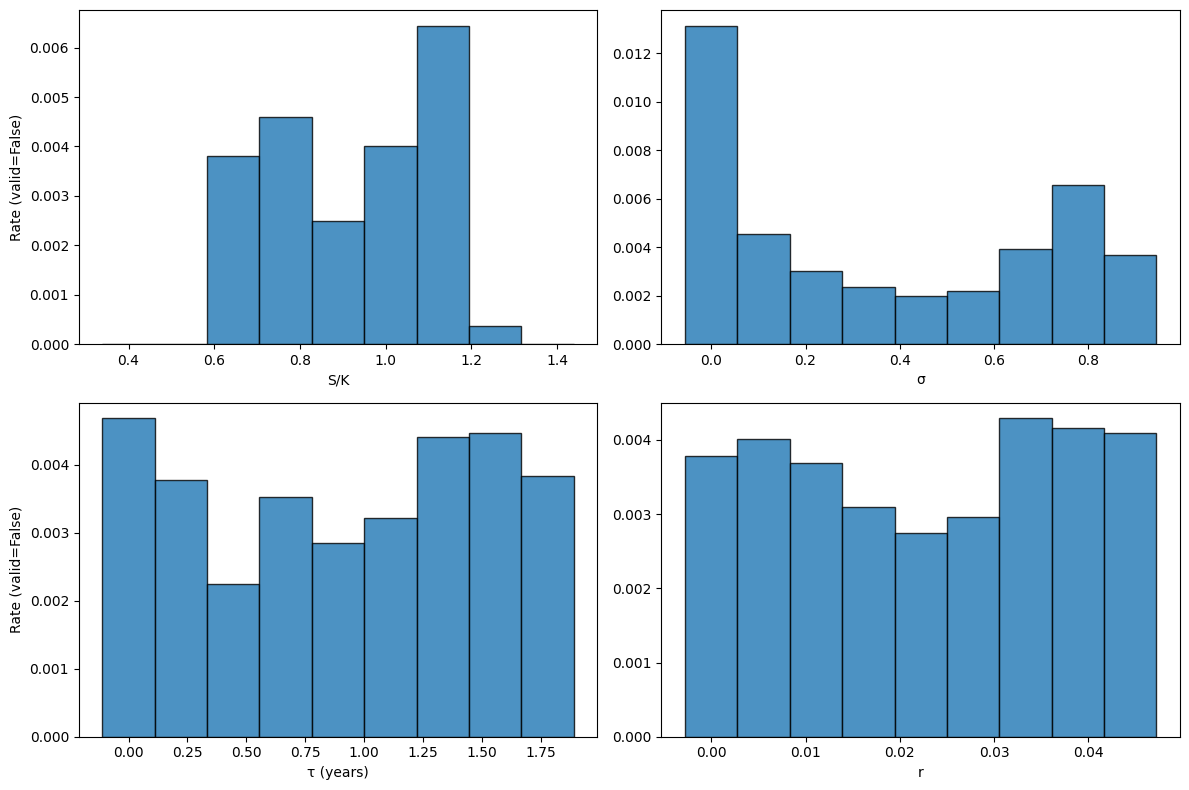

CQR - Invalid Point Prediction Analysis for Sample ID: 5
Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


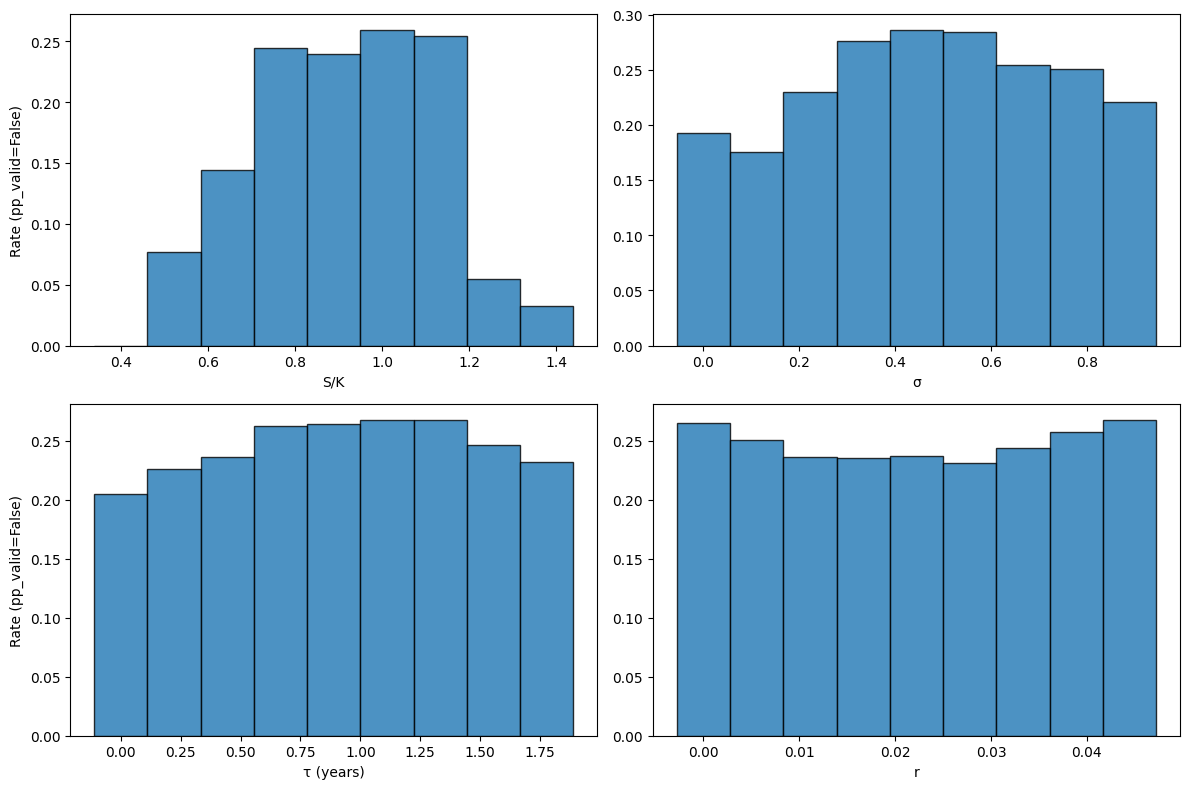

In [19]:
# Loop over CP prediction files with their sample sizes
for predictions_path, (sample_id, sample_size) in cp_prediction_files.items():
    print(f"Processing CP Predictions for Sample ID: {sample_id}")
    plot_prediction_intervals(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="CQR", sample_id=sample_id, sample_size=sample_size, n=500, save=True
    )
    plot_missed_rate(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="CQR", bins=bins, sample_id=sample_id, save=True
    )
    plot_invalid_intervals(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="CQR", bins=bins, sample_id=sample_id, save=True
    )
    plot_invalid_pp(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="CQR", bins=bins, sample_id=sample_id, save=True
    )

Processing Non-CP Predictions for Sample ID: 0
NQR - Prediction Intervals for Sample ID: 0
Training Sample Size: 5,000
Covered Intervals: 246,290
Missed Intervals: 253,710
Note: Every 500-th data point is plotted.

Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


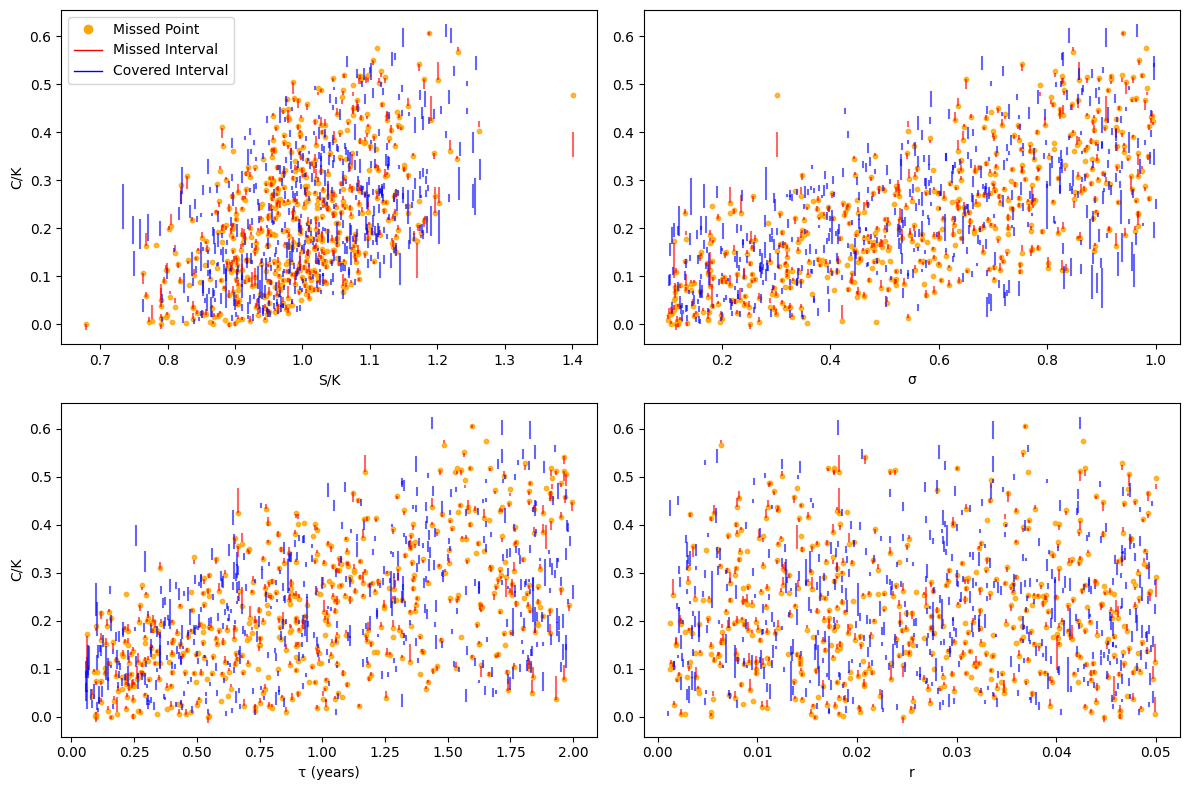

NQR - Missed Rate Analysis for Sample ID: 0
Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


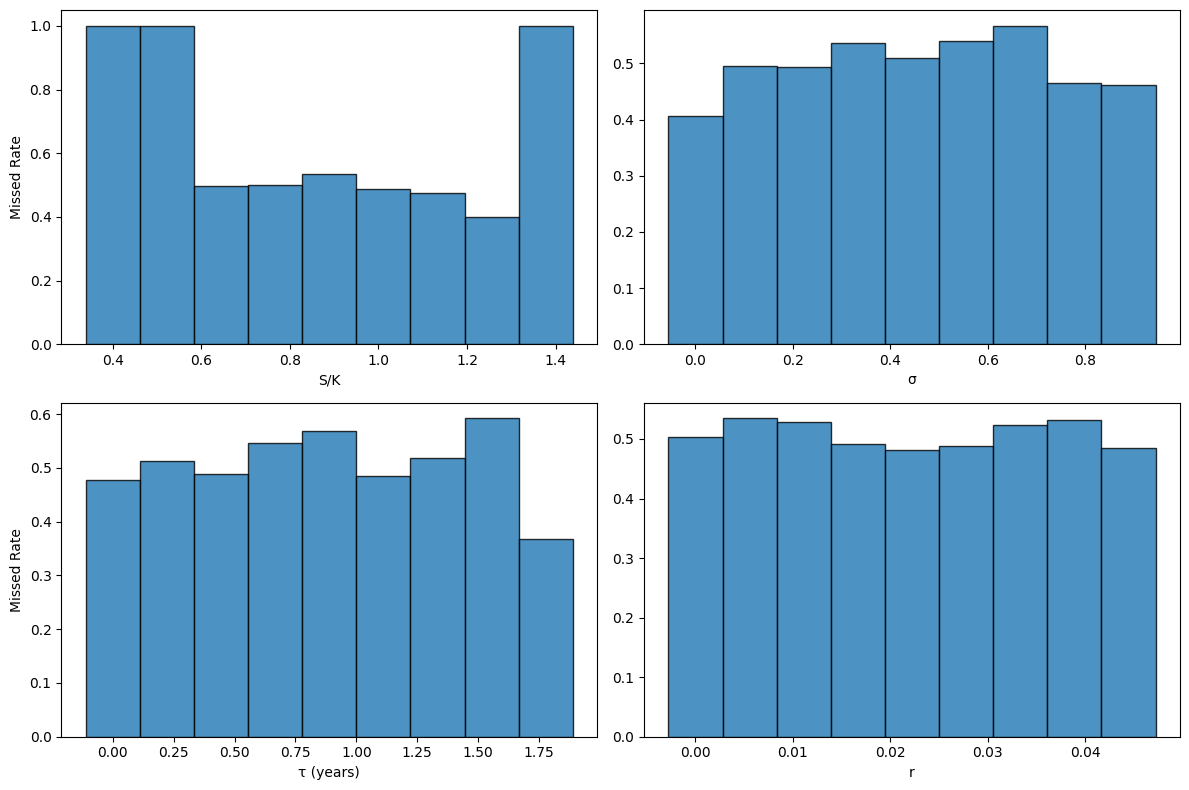

NQR - Invalid Interval Analysis for Sample ID: 0
Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


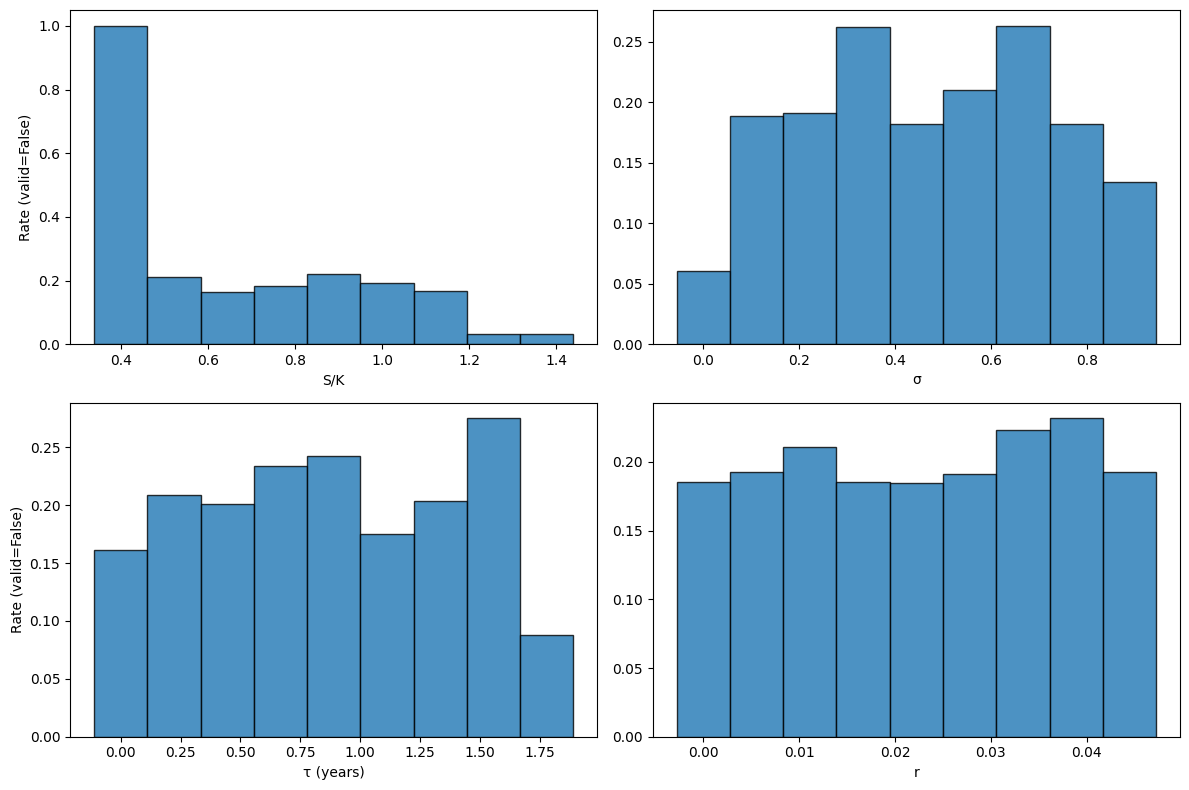

NQR - Invalid Point Prediction Analysis for Sample ID: 0
Plot saved to Google Drive in folder ID: 1xGVPSjVc5hHB5JmWxmhLJWjucisRPKfa


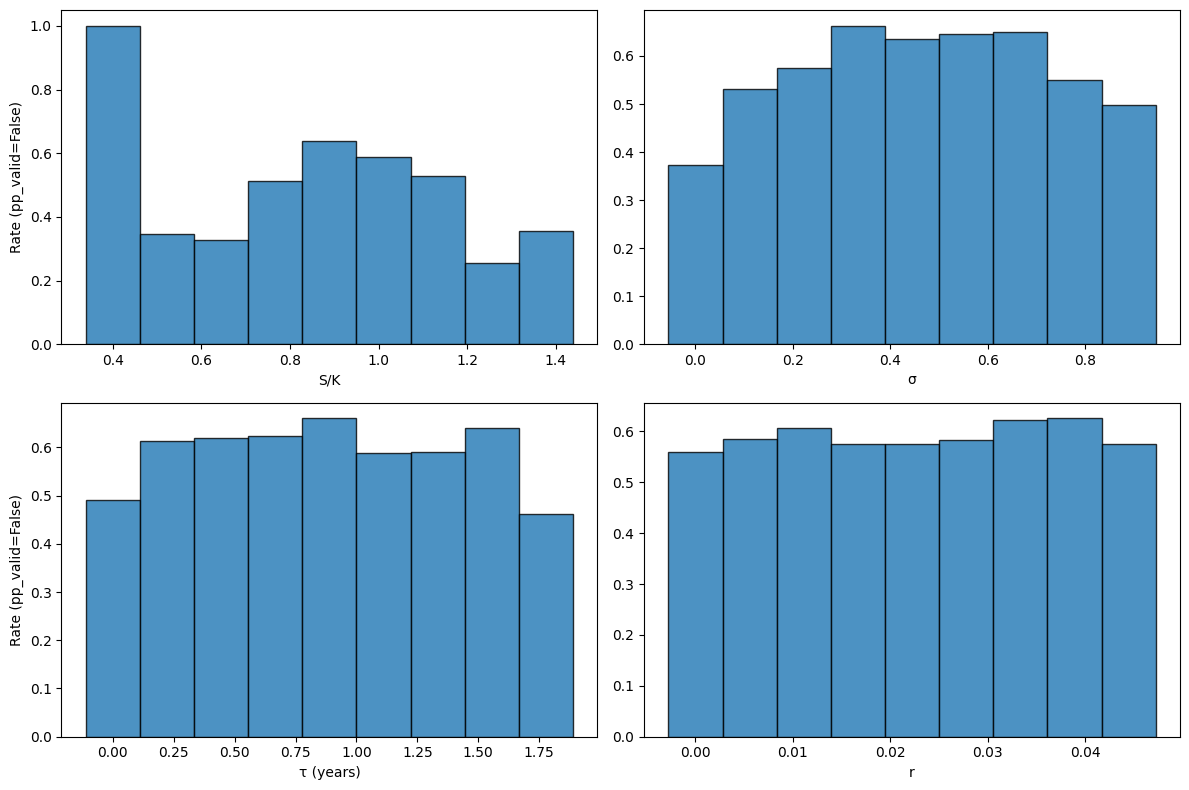

Processing Non-CP Predictions for Sample ID: 5
NQR - Prediction Intervals for Sample ID: 5
Training Sample Size: 200,000
Covered Intervals: 354,422
Missed Intervals: 145,578
Note: Every 500-th data point is plotted.

Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


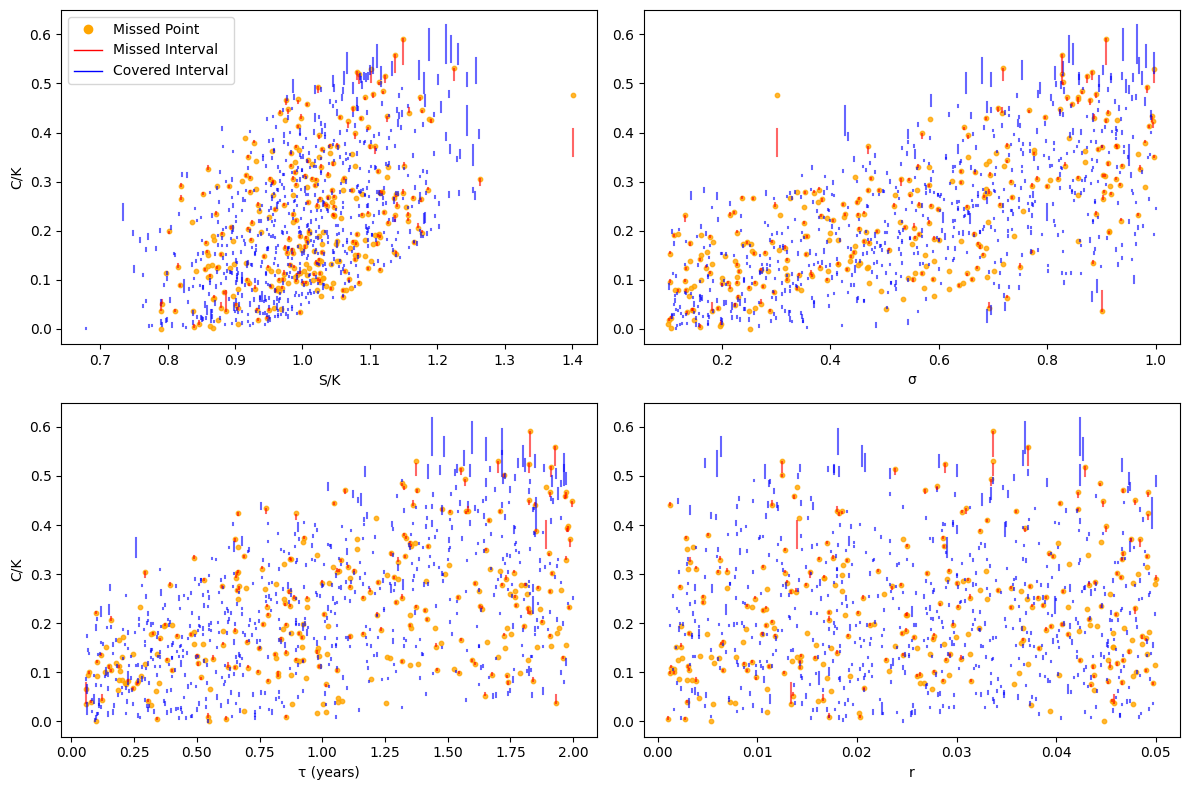

NQR - Missed Rate Analysis for Sample ID: 5
Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


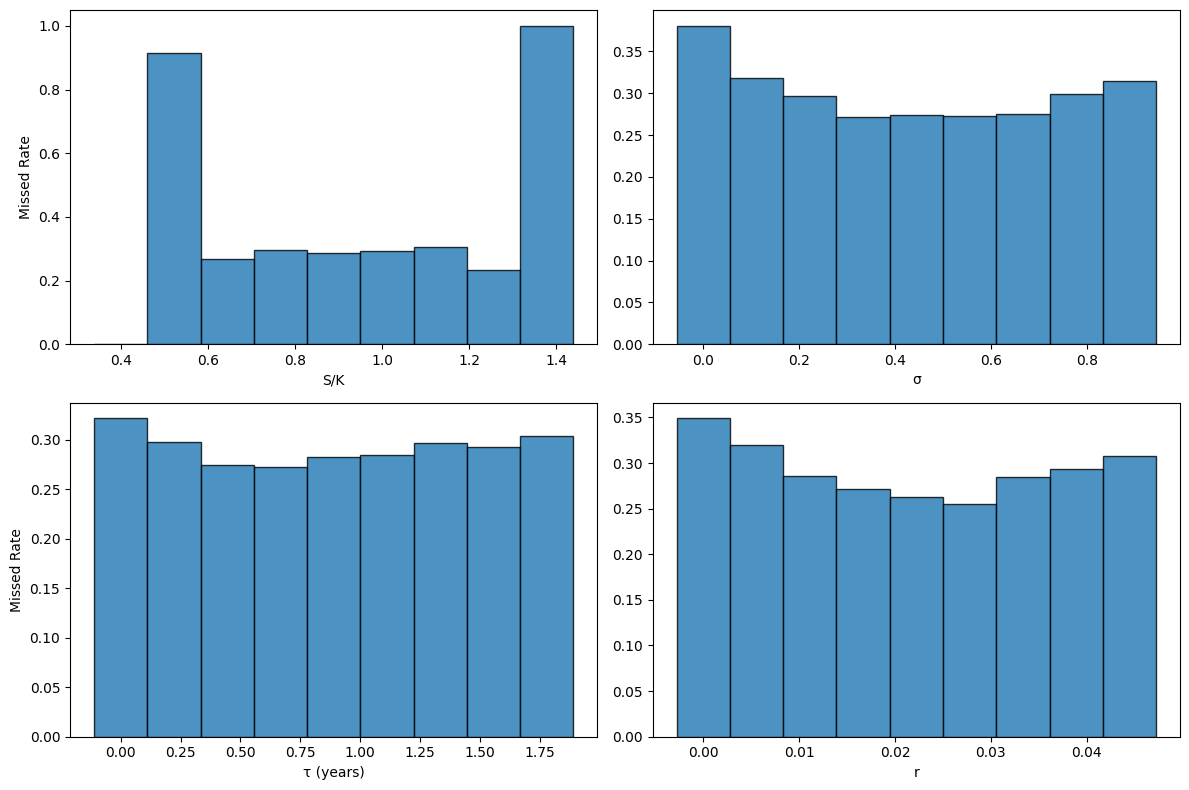

NQR - Invalid Interval Analysis for Sample ID: 5
Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


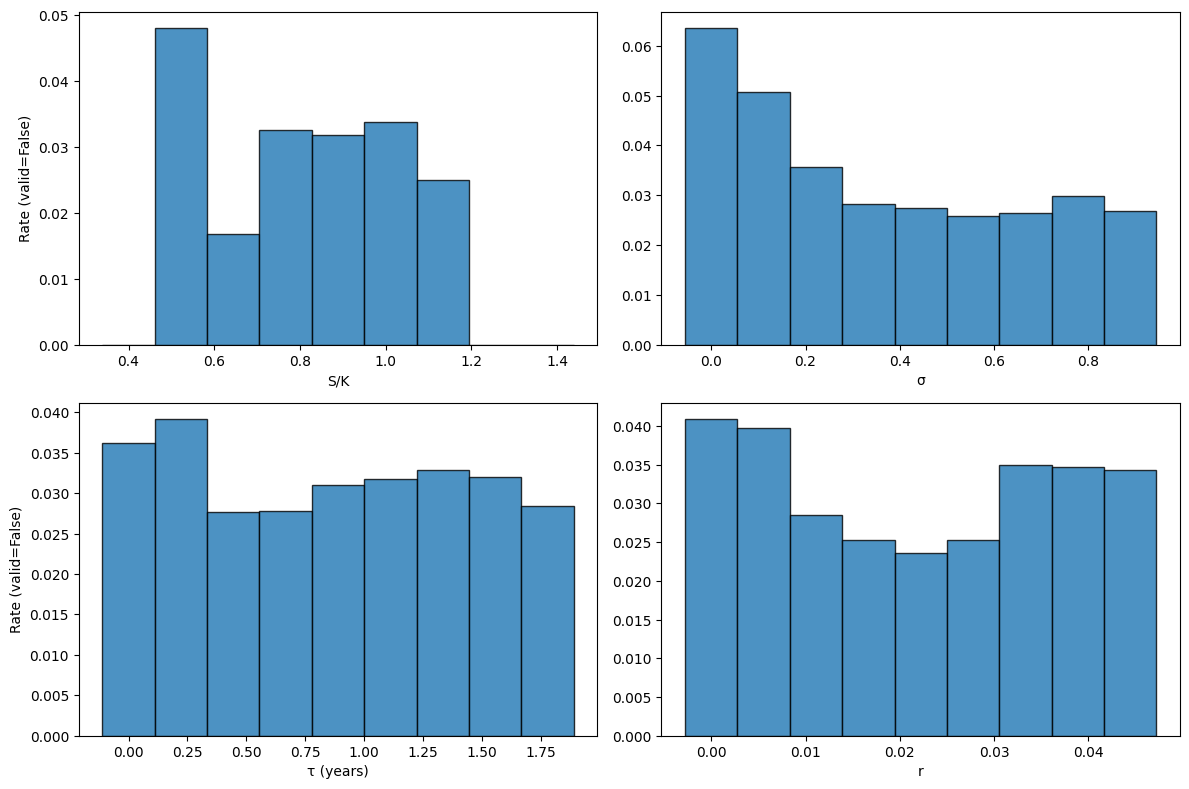

NQR - Invalid Point Prediction Analysis for Sample ID: 5
Plot saved to Google Drive in folder ID: 15tmbrSmV8rZoA5Fpg3D57BT2WhS6Fbg1


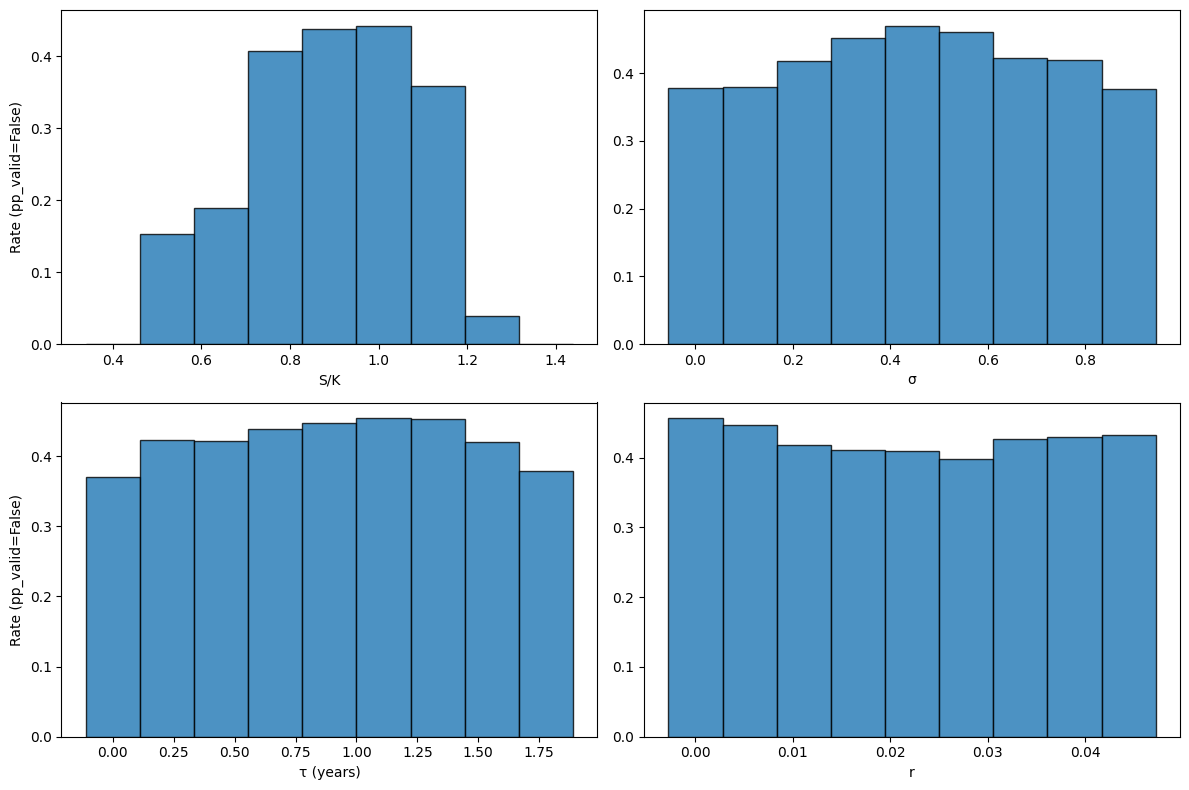

In [13]:
# Loop over Non-CP prediction files with their sample sizes
for predictions_path, (sample_id, sample_size) in non_cp_prediction_files.items():
    print(f"Processing Non-CP Predictions for Sample ID: {sample_id}")
    plot_prediction_intervals(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="NQR", sample_id=sample_id, sample_size=sample_size, n=500, save=True
    )
    plot_missed_rate(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="NQR", bins=bins, sample_id=sample_id, save=True
    )
    plot_invalid_intervals(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="NQR", bins=bins, sample_id=sample_id, save=True
    )
    plot_invalid_pp(
        predictions_path=predictions_path, test_data_path=test_data_path,
        method_name="NQR", bins=bins, sample_id=sample_id, save=True
    )